<a href="https://colab.research.google.com/github/phakornintt/channel_network_extraction/blob/main/Tutorial_SeniorProject_Channel_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial_SeniorProject_Channel_Extraction

This is result of my senior project!

If you want to get my model to train your data. 

please feel free to get it!

## Step1:Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install -U torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 25kB/s 
     |████████████████████████████████| 6.7MB 53.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.1+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 296kB 14.6MB/s 
     |████████████████████████████████| 194kB 26.1MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.4-cp37-cp37m-linux_x86_64.whl size=24823393 sha256=2a1daa1d56eafcd346a0bc438989bc56f2c054c3f9eb376f9a8e7850991adaf8
  Stored in directory: /root/.cache/pip/wheels/d4/39/64/573a0673de0ee0c6b699dddfae8232d485ea8da749caa198fd
Successfully built mmcv-full
Cloni

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.12.0
11.0
GCC 7.5


## Step1: Transform input image to classified image wtih Kmeans clustering

In [31]:
! git clone https://github.com/phakornintt/channel_network_extraction/
%cd channel_network_extraction/data_collection

Cloning into 'channel_network_extraction'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.
/content/mmdetection/channel_network_extraction/data_collection/channel_network_extraction/data_collection


In [32]:
!pip install imagecodecs==2021.1.28
!pip install scikit-learn==0.24.1
!pip install scikit-image==0.18.1

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


mkdir: cannot create directory ‘/content/transform_kmean’: File exists
save single band as jpg: /content/transform_kmean/test_002.jpg


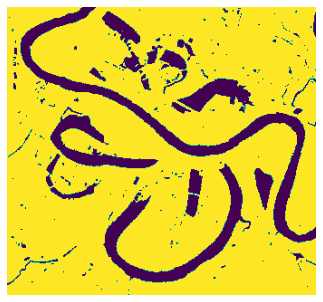

In [2]:
import core as c
import skimage.io as skio

from sklearn.cluster import KMeans

!mkdir /content/transform_kmean

directory = "/content/"   # input path of your tifffile
filename = 'test_002.tif' # please change  filename if you have more than 1 image
# TODO import data
# Sentinel-2 MSI: MultiSpectral Instrument, Level-2A
stacked_images = skio.imread(directory+filename, plugin="tifffile")


# TODO cleaning data contained NaN
stacked_images, _, _ = c.cleaning_data(stacked_images)

# # TODO save rgb image
# folder = '/content/transform_kmean/'
# name = 'image'
# filepath = '/content/transform_kmean/' + 'rgb_' + filename[:-4] + '.jpg'
# print('save rgb as jpg:', filepath)
# c.save_rgb_jpg(stacked_images, 2, filepath, fig=None)

'''
keep in mind the true band order might not follow this sequence
0  B1	Aerosols			60 meters (bad)
1  B2	Blue			    10 meters (moderate)
2  B3	Green			    10 meters (moderate)
3  B4	Red			        10 meters (moderate)
4  B5	Red Edge 1			20 meters (moderate)
5  B6	Red Edge 2			20 meters (good)
6  B7	Red Edge 3			20 meters (good)
7  B8	NIR			        10 meters (good)
8  B8A	Red Edge 4			20 meters (good)
9  B9	Water vapor			60 meters (good)
10 B11	SWIR 1			    20 meters (moderate)
11 B12	SWIR 2			    20 meters (moderate)	
'''

# TODO K-means

images_2D = stacked_images[:, :, 7]
vector_data = images_2D.reshape(-1, 1) # flatten matrix to vector for each band (row * col, 3) 
number_of_classes = 2
random_centroid = 42 # interger number range 0-42
kmeans = KMeans(n_clusters = number_of_classes, random_state = random_centroid).fit(vector_data)
kmeans = kmeans.cluster_centers_[kmeans.labels_]
kmeans = kmeans.reshape(images_2D.shape)

filepath = '/content/transform_kmean/' + filename[:-4] + '.jpg'
print('save single band as jpg:', filepath)
c.save_jpg(kmeans, filepath, fig=None)

In [3]:
%cd /content/mmdetection

/content/mmdetection


### Download trained model parameters

In [4]:
!mkdir checkpoints
!wget -c https://mmdatasets.s3-ap-southeast-1.amazonaws.com/faster_rcnn_r50_mAP0.7_v6.pth \
      -O checkpoints/faster_rcnn_r50_mAP0.7_v6.pth
!wget https://mmdatasets.s3-ap-southeast-1.amazonaws.com/faster_rcnn_r50_caffe_fpn_mstrain.py
!wget https://mmdatasets.s3-ap-southeast-1.amazonaws.com/faster_rcnn_r50_fpn.py

mkdir: cannot create directory ‘checkpoints’: File exists
--2021-05-14 11:55:40--  https://mmdatasets.s3-ap-southeast-1.amazonaws.com/faster_rcnn_r50_mAP0.7_v6.pth
Resolving mmdatasets.s3-ap-southeast-1.amazonaws.com (mmdatasets.s3-ap-southeast-1.amazonaws.com)... 52.219.32.123
Connecting to mmdatasets.s3-ap-southeast-1.amazonaws.com (mmdatasets.s3-ap-southeast-1.amazonaws.com)|52.219.32.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-05-14 11:55:41--  https://mmdatasets.s3-ap-southeast-1.amazonaws.com/faster_rcnn_r50_caffe_fpn_mstrain.py
Resolving mmdatasets.s3-ap-southeast-1.amazonaws.com (mmdatasets.s3-ap-southeast-1.amazonaws.com)... 52.219.32.123
Connecting to mmdatasets.s3-ap-southeast-1.amazonaws.com (mmdatasets.s3-ap-southeast-1.amazonaws.com)|52.219.32.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1507 (1.5K) [binary/octet-stream]


In [5]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
# config = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py'
config = './faster_rcnn_r50_caffe_fpn_mstrain.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_mAP0.7_v6.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

Use load_from_local loader


## Step3: upload your input images

In [8]:
# Use the detector to do inference
img = '/content/transform_kmean/test_002.jpg'    # please change directory of input image
result = inference_detector(model, img)

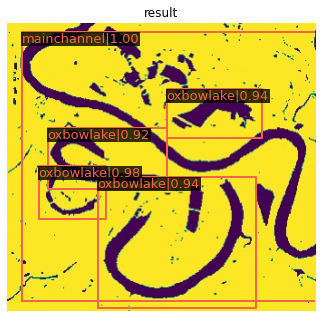

In [9]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.9)

In [15]:
# If you want to download the result please execute this cell

import os 

if os.path.isdir("/content/mmdetection/output") == True:
  pass
else:
  !mkdir output

model.show_result(img, result, out_file='output/{}'.format(img.split('/')[-1]), score_thr= 0.9)

## **Step4: Collect predicted bounding box coordinate to csv file**

In [16]:
import pandas as pd
import os
import numpy as np
import mmcv

# initialize dataframe
# df = pd.DataFrame({"image_name":[],"class":[],"num":[],"ymax":[],"ymin":[],"xmax":[],"xmin":[],"prob":[]})
df = pd.DataFrame({"image_name":[],"class":[],"num":[],"xmin":[],"ymin":[],"xmax":[],"ymax":[],"prob":[]})

### Excecute the code below for collect coordinate to Dataframe

In [17]:
directory = r'/content/transform_kmean/' # Please change the images directory
for filename in os.listdir(directory):
  # print(filename)
  img = mmcv.imread(directory+filename)

  result = inference_detector(model, img)

  i=1
  for r in result[0]:      # main_channel
    if r[4] > 0.9:

      r = np.reshape(r,[1,5])
      listofdata = np.array([filename,"main_channel",i])
      listofdata = np.append(listofdata,r)
      listofdata = np.reshape(listofdata,[1,8])
      df_test = pd.DataFrame(listofdata, columns =df.columns)
      df = df.append(df_test, ignore_index=True)   
    i+=1
  i=1    
  for r in result[1]:    # oxbow_lake
    if r[4] > 0.9:
      r = np.reshape(r,[1,5])
      listofdata = np.array([filename,"oxbow_lake",i])
      listofdata = np.append(listofdata,r)
      listofdata = np.reshape(listofdata,[1,8])
      df_test = pd.DataFrame(listofdata, columns =df.columns)
      df = df.append(df_test, ignore_index=True)   
    i+=1  

# columns_titles = ["image_name","class","num","xmin","ymin","xmax","ymax","prob"]
# df=df.reindex(columns=columns_titles)

In [18]:
df

,image_name,class,num,xmin,ymin,xmax,ymax,prob
0,test_002.jpg,main_channel,1,14.3276825,9.115818,308.0,278.02975,0.99506015
1,test_002.jpg,oxbow_lake,1,31.610924,143.68462,98.80894,196.52911,0.98393875
2,test_002.jpg,oxbow_lake,2,90.45106,154.74557,248.17334,285.35718,0.94419694
3,test_002.jpg,oxbow_lake,3,159.22908,66.59724,254.79257,115.63247,0.9363819
4,test_002.jpg,oxbow_lake,4,40.04077,105.812386,159.03603,166.64601,0.9197579


### Export to csv

In [19]:
df.to_csv('test_lr0.0025_thr0.9_v9.csv', index=False) # please named your .csv file

# **Step5:Calculate water surface**

## Crop the input images from csv file

In [20]:
import PIL.Image

In [21]:
df_2 = pd.read_csv("test_lr0.0025_thr0.9_v9.csv")
df_2

,image_name,class,num,xmin,ymin,xmax,ymax,prob
0,test_002.jpg,main_channel,1,14.327683,9.115818,308.00000,278.02975,0.995060
1,test_002.jpg,oxbow_lake,1,31.610924,143.684620,98.80894,196.52911,0.983939
2,test_002.jpg,oxbow_lake,2,90.451060,154.745570,248.17334,285.35718,0.944197
3,test_002.jpg,oxbow_lake,3,159.229080,66.597240,254.79257,115.63247,0.936382
4,test_002.jpg,oxbow_lake,4,40.040770,105.812386,159.03603,166.64601,0.919758


In [22]:
for index , row in df_2.iterrows():
    for filename in os.listdir(directory):
        if row[0] == filename:
            img = PIL.Image.open(directory+filename)
            left = row['xmin']
            top = row['ymin']
            right = row['xmax']
            bottom = row['ymax']
            crop = img.crop((left, top, right, bottom))
            crop.show()
            if os.path.isdir("/content/mmdetection/crop_output") == True:
              pass
            else:
              !mkdir crop_output
            crop.save('/content/mmdetection/crop_output/'+ str(row['class']) + '_'+ str(row['num'])+'_'+filename[0:-4]+'.png')

# **Step6:Image segmentation (Thongsang et al. 2021)**

In [23]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import sys
import cv2

from skimage import exposure 
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans

In [24]:
def compute_kmeans(data, number_of_classes, plot):
	images_2D = data[:, :]
	vector_data = images_2D.reshape(-1, 1) # flatten matrix to vector for each band (row * col, 3) 
	random_centroid = 42 # interger number range 0-42
	kmeans = KMeans(n_clusters = number_of_classes, random_state = random_centroid).fit(vector_data)
	kmeans = kmeans.cluster_centers_[kmeans.labels_]
	kmeans = kmeans.reshape(images_2D.shape)
	if plot == 'yes':
		plt.imshow(kmeans)
	elif plot == 'no':
		pass
	return kmeans

def image_segmentation(kmeans,level, save_file,oxb):
	# binary = np.where(kmeans >= kmeans.max()/2, 0, 1)
	# binary = convert_array_to_binary(kmeans)
	dummy = np.unique(kmeans)
	binary = np.where(kmeans > dummy[0], 0, 1)
	#? begin image segmentation
	label_out = label(binary, connectivity=1, return_num=False)
	collect = []
	index = 0
	for region in regionprops(label_out):
		(min_row, min_col, max_row, max_col) = region.bbox
		collect.append([region.area,region.bbox])
	collect = sorted(collect,reverse=True)
	
	for area in collect[level:]:
		(min_row, min_col, max_row, max_col) = area[1]
		binary[min_row:max_row, min_col:max_col] = 0
	for area in collect[0:level]:
		if area[0] < 100:
			(min_row, min_col, max_row, max_col) = area[1]
			binary[min_row:max_row, min_col:max_col] = 0
	# print(binary.shape[0],binary.shape[1])
	# print(collect)
	plt.imshow(binary,cmap='viridis_r')
	plt.tight_layout()
 
	return binary
 

def count_number_of_pixel(cleaned_kmeans):
	cleaned_kmeans = cleaned_kmeans.flatten()
	count = 0
	for i in range (0, len(cleaned_kmeans)):
		if cleaned_kmeans[i] == 1.:
			count += 1
	return count

In [29]:
directory = "/content/mmdetection/crop_output/"

if os.path.isdir("/content/mmdetection/result") == True:
    pass
else:
    !mkdir result

df_3 = pd.DataFrame({"filename":[],"water_surface(m^2)":[]})
df_3

,filename,water_surface(m^2)


Completed..! please check the image in result folder on the left side


,filename,water_surface(m^2)
0,oxbow_lake_2_test_002.png,316600.0
1,oxbow_lake_1_test_002.png,48200.0
2,main_channel_1_test_002.png,1004700.0
3,oxbow_lake_3_test_002.png,117200.0
4,oxbow_lake_4_test_002.png,177100.0


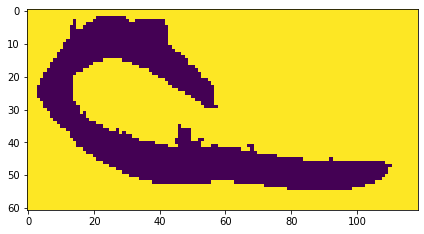

In [30]:
for filename in os.listdir(directory):
    if filename[0] == "o": # specific oxbowlake
        img = cv2.imread(directory+filename,2)
        kmeans = compute_kmeans(img,2,'no')
        min_pixel, max_pixel = 0,50
        cleaned_kmeans = image_segmentation(kmeans,1, 'test.svg','on')
        plt.savefig('/content/mmdetection/result/'+filename[:-4]+'.png',format = "png")
        # print(type(cleaned_kmeans))
        n_pix = count_number_of_pixel(cleaned_kmeans)
        water_surface = n_pix*100
        df_3 = df_3.append({"filename":filename,"water_surface(m^2)":water_surface}, ignore_index=True)
    else: #main channel
        img = cv2.imread(directory+filename,2)
        kmeans = compute_kmeans(img,2,'no')
        cleaned_kmeans = image_segmentation(kmeans,3, 'test.svg','off')
        plt.savefig('/content/mmdetection/result/'+filename[:-4]+'.png',format = "png")
        n_pix = count_number_of_pixel(cleaned_kmeans)
        water_surface = n_pix*100
        df_3 = df_3.append({"filename":filename,"water_surface(m^2)":water_surface}, ignore_index=True)
print("Completed..! please check the image in result folder on the left side")
df_3

In [27]:
df_3.to_csv('xxxxx.csv', index=False) # please named your .csv file